# Instagram Likes Classifier

In [162]:
# installations
!pip install pillow pandas exifread
!pip install opencv-python

In [163]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

### EDA/Data Preparation

In [164]:
# read the Instagram data and display data frame
instagram_data = pd.read_csv("instagram_data.csv")
instagram_data.head()

,likes,no_of_comments,t,follower_count_at_t,image_path
0,154552,0,1594174009,40934474,../Data/insta_data/0.jpg
1,97386,0,1593571666,40934474,../Data/insta_data/2.jpg
2,145632,0,1593136341,40934474,../Data/insta_data/4.jpg
3,76461,0,1592981047,40934474,../Data/insta_data/6.jpg
4,174620,0,1592703461,40934474,../Data/insta_data/8.jpg


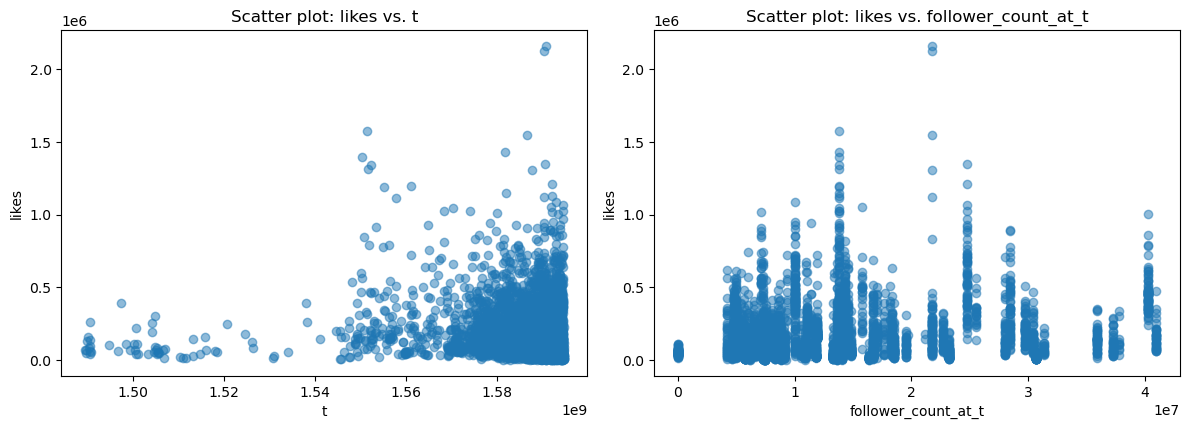

In [165]:
# plotting likes v. t, follower_count_at_t	
predictor_vars = ['t', 'follower_count_at_t']
plt.figure(figsize=(12, 8)) 
for i, predictor in enumerate(predictor_vars):
    plt.subplot(2, 2, i + 1) 
    plt.scatter(instagram_data[predictor], instagram_data['likes'], alpha=0.5)
    plt.title(f'Scatter plot: likes vs. {predictor}')
    plt.xlabel(predictor)
    plt.ylabel('likes')

plt.tight_layout()
plt.show()

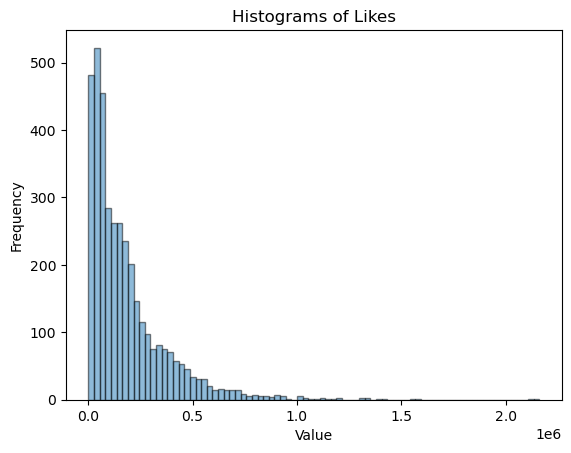

Min number of likes: 1431
Max number of likes: 2161369


In [166]:

instagram_data['likes'].plot(kind='hist', bins=80, edgecolor='black', alpha=0.5)
plt.title('Histograms of Likes')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()
print("Min number of likes: "+str(min(instagram_data['likes'])))
print("Max number of likes: "+str(max(instagram_data['likes'])))

Text(0, 0.5, 'Frequency')

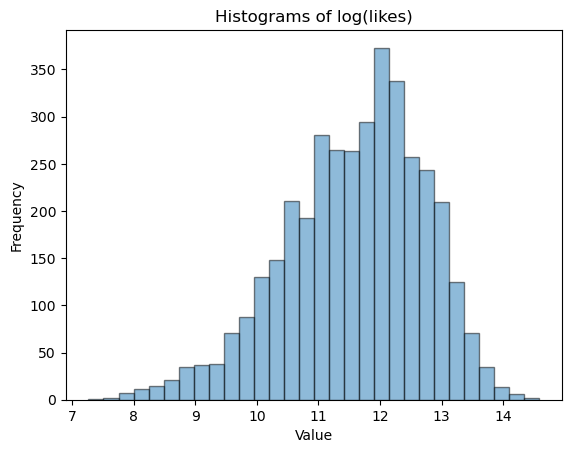

In [167]:
np.log(instagram_data['likes']).plot(kind='hist', bins=30, edgecolor='black', alpha=0.5)
plt.title('Histograms of log(likes)')
plt.xlabel('Value')
plt.ylabel('Frequency')

In [168]:
# change image path to relative path of notebook
instagram_data['image_path'] = instagram_data['image_path'].str.replace('../Data/', '', regex=False)
instagram_data.head()

,likes,no_of_comments,t,follower_count_at_t,image_path
0,154552,0,1594174009,40934474,insta_data/0.jpg
1,97386,0,1593571666,40934474,insta_data/2.jpg
2,145632,0,1593136341,40934474,insta_data/4.jpg
3,76461,0,1592981047,40934474,insta_data/6.jpg
4,174620,0,1592703461,40934474,insta_data/8.jpg


### Extracting Metadata From Images

In [169]:
# helper functions used to extract image metadata
def calculate_brightness(image_path):
    with Image.open(image_path).convert('L') as img:
        np_img = np.array(img)
        brightness = np.mean(np_img)
    return brightness

def calculate_sharpness(image_path):
    with Image.open(image_path) as img:
        gray_img = img.convert('L')
        np_img = np.array(gray_img)
        laplacian = cv2.Laplacian(np_img, cv2.CV_64F)
        sharpness = laplacian.var()
    return sharpness

def calculate_contrast(image_path):
    with Image.open(image_path).convert('L') as img:
        np_img = np.array(img)
        min_pixel = np.min(np_img)
        max_pixel = np.max(np_img)
        contrast = max_pixel - min_pixel
    return contrast

def detect_blurriness(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    return laplacian_var



In [170]:
from tqdm import tqdm

tqdm.pandas() 

instagram_data['sharpness'] = instagram_data['image_path'].progress_apply(calculate_sharpness)
instagram_data['contrast'] = instagram_data['image_path'].progress_apply(calculate_contrast)
instagram_data['blurriness'] = instagram_data['image_path'].progress_apply(detect_blurriness)


100%|██████████| 3785/3785 [00:44<00:00, 85.99it/s] 


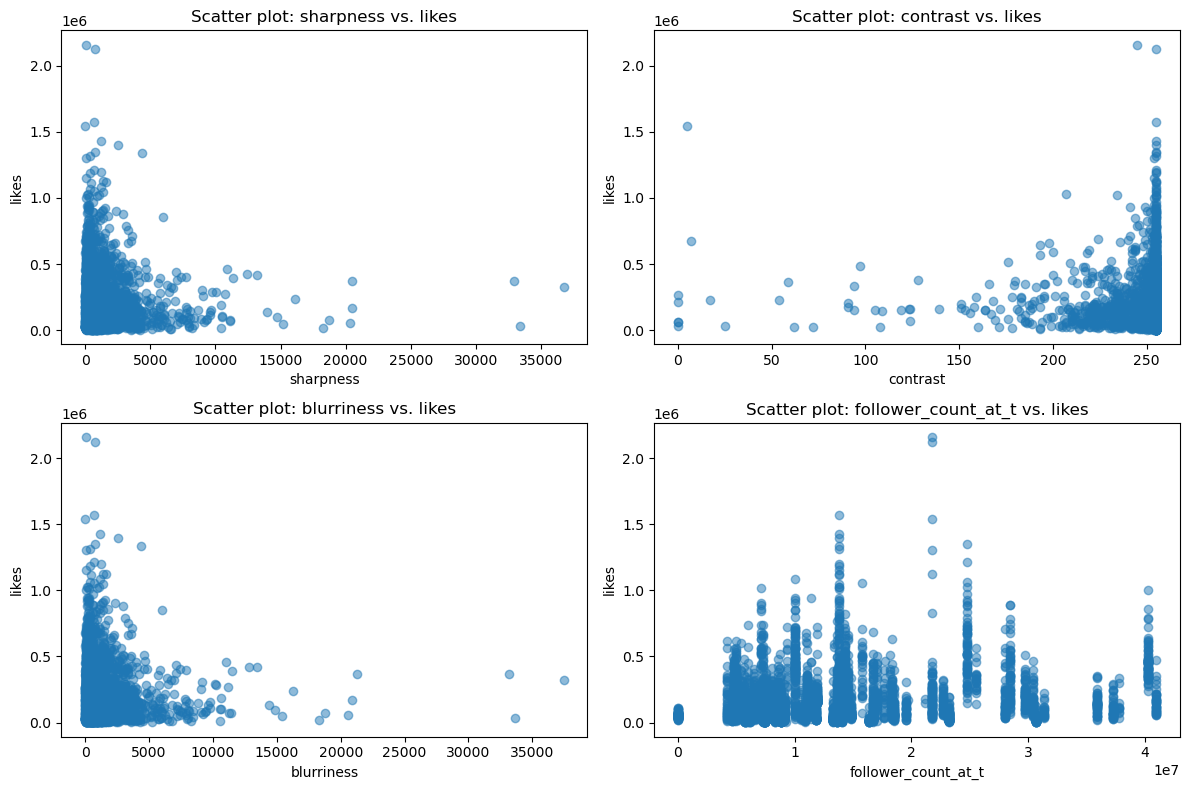

In [171]:
# plotting likes v. metadata features, followers
predictor_vars = ['sharpness', 'contrast', 'blurriness', 'follower_count_at_t']
plt.figure(figsize=(12, 8)) 
for i, predictor in enumerate(predictor_vars):
    plt.subplot(2, 2, i + 1) 
    plt.scatter(instagram_data[predictor], instagram_data['likes'], alpha=0.5)
    plt.title(f'Scatter plot: {predictor} vs. likes')
    plt.xlabel(predictor)
    plt.ylabel('likes')

plt.tight_layout()
plt.show()

### Creating Classes

In [172]:
# perform K-Means clustering to find 3 groups for likes
likes = instagram_data['likes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(likes)
instagram_data['likes_class'] = labels

# calculate the minimum and maximum likes in each cluster
cluster_ranges = {}
for label in np.unique(labels):
    label_data = instagram_data[instagram_data['likes_class'] == label]['likes']
    cluster_ranges[label] = (label_data.min(), label_data.max())

# sort clusters by their min value
sorted_clusters = sorted(cluster_ranges.items(), key=lambda x: x[1][0])
cluster_mapping = {cluster[0]: idx for idx, cluster in enumerate(sorted_clusters)}

# map the clusters to the new labels
instagram_data['likes_class'] = instagram_data['likes_class'].map(cluster_mapping)

# calculate the percentage of values in each class
class_counts = instagram_data['likes_class'].value_counts()
total_count = len(instagram_data)
percentages = (class_counts / total_count) * 100

print("Percentage of data in each class:")
for label, percent in percentages.items():
    print(f"Class {label}: {percent:.2f}%")
print()

# get the range of number of likes in each class
for label in sorted(np.unique(instagram_data['likes_class'])):
    label_data = instagram_data[instagram_data['likes_class'] == label]['likes']
    min_value = label_data.min()
    max_value = label_data.max()
    print(f"Class {label}: {min_value} to {max_value} likes")

Percentage of data in each class:
Class 0: 71.57%
Class 1: 24.02%
Class 2: 4.41%

Class 0: 1431 to 218688 likes
Class 1: 218801 to 574494 likes
Class 2: 575590 to 2161369 likes


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Training/Testing Models

In [173]:
features = ['sharpness', 'contrast', 'blurriness', 'follower_count_at_t']
X = instagram_data[features]
y = instagram_data['likes_class']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN Classifier': KNeighborsClassifier(n_neighbors=3),
    'SVM Classifier': SVC(),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting Classifier': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# train and evaluate each model
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    results[model_name] = {
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy
    }

# report the results
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Train Accuracy: {metrics['Train Accuracy']:.4f}")
    print(f"  Test Accuracy: {metrics['Test Accuracy']:.4f}")
    print()

Logistic Regression:
  Train Accuracy: 0.7193
  Test Accuracy: 0.7015

KNN Classifier:
  Train Accuracy: 0.8854
  Test Accuracy: 0.7847

SVM Classifier:
  Train Accuracy: 0.7193
  Test Accuracy: 0.7015

Random Forest Classifier:
  Train Accuracy: 1.0000
  Test Accuracy: 0.7596

Gradient Boosting Classifier:
  Train Accuracy: 0.8398
  Test Accuracy: 0.7992



### Investigating KNN Model

Optimal number of neighbors (k): 9
Test Accuracy for optimal k: 0.8129


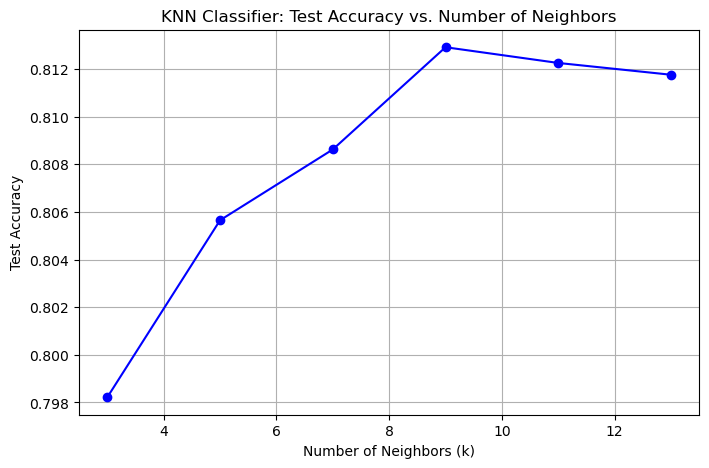

In [174]:
# paramter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'p': [2]
}

# initialize the KNN Classifier and GridSearchCV with the same split
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)

# fit GridSearchCV on the same training set
grid_search_knn.fit(X_train, y_train)

results_knn = grid_search_knn.cv_results_

mean_test_scores = results_knn['mean_test_score']
param_values = param_grid_knn['n_neighbors']

# reshape mean_test_scores to match the structure of `n_neighbors` values
mean_test_scores_reshaped = np.array(mean_test_scores).reshape(
    len(param_values),
    len(param_grid_knn['weights']),
    len(param_grid_knn['p'])
)

# aggregate test scores for all `weights` and `p` values
mean_test_scores_for_k = mean_test_scores_reshaped.mean(axis=(1, 2))

# find the optimal k and its test accuracy
optimal_index = np.argmax(mean_test_scores_for_k)
optimal_k = param_values[optimal_index]
optimal_test_accuracy = mean_test_scores_for_k[optimal_index]

# plot the results
plt.figure(figsize=(8, 5))
plt.plot(param_values, mean_test_scores_for_k, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Test Accuracy')
plt.title('KNN Classifier: Test Accuracy vs. Number of Neighbors')
plt.grid(True)

# print the optimal k and its test accuracy
print(f"Optimal number of neighbors (k): {optimal_k}")
print(f"Test Accuracy for optimal k: {optimal_test_accuracy:.4f}")
plt.show()

### Feature Contribution of KNN Classifier

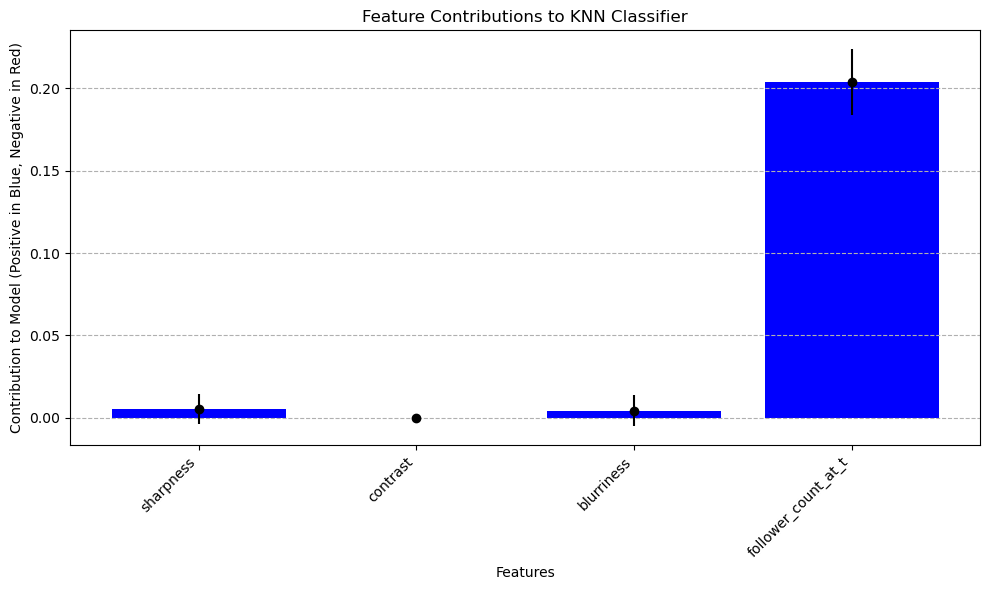

Feature Importances:
               Feature  Importance  Standard Deviation Color
0            sharpness    0.005152            0.009065  blue
1             contrast    0.000000            0.000591  blue
2           blurriness    0.004359            0.009490  blue
3  follower_count_at_t    0.203699            0.019971  blue


In [175]:
# calculate permutation importance
result = permutation_importance(grid_search_knn.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# extract importances and feature names
importances = result.importances_mean
std = result.importances_std
feature_names = X.columns

# create a DataFrame for better visualization
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances,
    'Standard Deviation': std
})

# set color based on importance
importances_df['Color'] = np.where(importances >= 0, 'blue', 'red')

# plot feature contributions
plt.figure(figsize=(10, 6))  # Adjusted size
bars = plt.bar(importances_df['Feature'], importances_df['Importance'], color=importances_df['Color'])

# add error bars
plt.errorbar(importances_df['Feature'], importances_df['Importance'], yerr=importances_df['Standard Deviation'], fmt='o', color='black')

# add labels and title
plt.xlabel('Features')
plt.ylabel('Contribution to Model (Positive in Blue, Negative in Red)')
plt.title('Feature Contributions to KNN Classifier')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

# print feature importances for reference
print("Feature Importances:")
print(importances_df)
